In [ ]:
# import dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
import numpy as np
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)

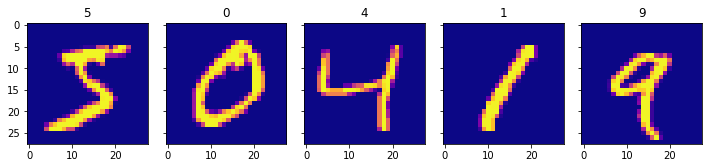

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

# visualize the data
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,6))
axs = axs.flatten()
for i in range(0,5):
    im = X[i]
    im = im.reshape(-1,28,28,1)
    axs[i].imshow(im[0,:,:,0], cmap=plt.get_cmap('plasma'))
    axs[i].set_title(y[i])
plt.tight_layout()
plt.show()

In [ ]:
# separate into 90% train set and 10% test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, train_size=0.90, random_state=42)

In [ ]:
# make sure the shapes line up
X_train.shape

(63000, 784)

In [ ]:
X_test.shape

(7000, 784)

In [ ]:
y_train.shape

(63000,)

In [ ]:
y_test.shape

(7000,)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# normalize the data - RGB values need to be divided by 255
# y values can be one hot encoded
def normalize(X):
  return (X/255).astype(np.float32)

In [ ]:
X_train, X_test = normalize(X_train), normalize(X_test)

#scaler = StandardScaler()
#X_train, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [ ]:
# reusable function that I will be using the report the different kernel results
def report_results(X, y, clf):
  predicted = clf.predict(X)
  #results = confusion_matrix(y, predicted)
  #print('Confusion Matrix: ')
  #print(results)
  print('Accuracy Score: ', accuracy_score(y, predicted))
  print("Report: ")
  print(classification_report(y, predicted))

In [ ]:
# start training models
# first I'm going to try Kneighbors - without a gridsearch
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
report_results(X_test, y_test, knn)

Accuracy Score:  0.9661428571428572
Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       683
           1       0.94      0.99      0.97       800
           2       0.97      0.96      0.96       674
           3       0.96      0.96      0.96       760
           4       0.98      0.97      0.97       611
           5       0.96      0.96      0.96       658
           6       0.98      0.99      0.98       677
           7       0.96      0.96      0.96       724
           8       0.98      0.92      0.95       693
           9       0.96      0.96      0.96       720

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000



Pretty good first score - it took forever to run without parameter tuning so instead of trying that I'm going to try some other models

In [ ]:
# Next I'll try a oVr classifier with an SVC
from sklearn.svm import SVC

# smaller sets for a quicker gridsearch
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, test_size=0.05, train_size=0.20, random_state=42)

# helper function that will allow me to cleanly perform GridSearch's
def svc_param_selection(X, y, nfolds):
    Cs = [1, 5]
    gammas = [0.01, 0.05]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
# perform the GridSearch and return the best params
rbf_params = svc_param_selection(X_train_small, y_train_small, 3)

In [ ]:
# view the best params
rbf_params

{'C': 1, 'gamma': 0.01}

In [ ]:
# Gaussian RBF
svm_clf_rbf = SVC(kernel="rbf", C=1, gamma=0.01) 

In [ ]:
# fit training data into the guassian rbf model
svm_clf_rbf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# report the results
report_results(X_test, y_test, svm_clf_rbf)

Accuracy Score:  0.9724285714285714
Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       683
           1       0.98      0.99      0.98       800
           2       0.96      0.97      0.97       674
           3       0.96      0.96      0.96       760
           4       0.97      0.97      0.97       611
           5       0.97      0.97      0.97       658
           6       0.98      0.99      0.98       677
           7       0.98      0.97      0.97       724
           8       0.97      0.96      0.96       693
           9       0.97      0.96      0.97       720

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000



In [ ]:
# Gaussian RBF
svm_clf_rbf = SVC(kernel="poly", C=0.001, gamma=10) 

In [ ]:
# fit training data into the guassian rbf model
svm_clf_rbf.fit(X_train, y_train)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# report the results
poly_results = report_results(X_test, y_test, svm_clf_rbf)

Accuracy Score:  0.9774285714285714
Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       683
           1       0.99      0.99      0.99       800
           2       0.96      0.99      0.97       674
           3       0.97      0.96      0.97       760
           4       0.98      0.98      0.98       611
           5       0.97      0.98      0.97       658
           6       0.99      0.99      0.99       677
           7       0.98      0.98      0.98       724
           8       0.98      0.96      0.97       693
           9       0.98      0.96      0.97       720

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000



In [ ]:
# the polynomial SVM seems to produce the best results